# Frequentist Model Selection with AIC/BIC

This notebook demonstrates systematic model comparison using **frequentist information criteria** (AIC, BIC) and the `ModelComparisonPipeline` API. This complements the Bayesian approach (WAIC/LOO) shown in `bayesian/04-model-comparison.ipynb`.

**Learning Objectives:**
- Use `ModelComparisonPipeline` for automated model comparison
- Understand AIC (Akaike Information Criterion) and BIC (Bayesian Information Criterion)
- Calculate AIC weights and evidence ratios for model selection
- Interpret complexity vs performance trade-offs
- Compare frequentist (AIC/BIC) vs Bayesian (WAIC/LOO) model selection

**Prerequisites:** Basic understanding of model fitting (complete basic/ notebooks first)

**Estimated Time:** 40-45 minutes

**Companion Notebook:** Use `bayesian/04-model-comparison.ipynb` for Bayesian model selection with WAIC/LOO

**Key Concepts:**
- **AIC** (Akaike Information Criterion): Penalizes complexity based on number of parameters
- **BIC** (Bayesian Information Criterion): Stronger complexity penalty than AIC
- **ΔAIC < 2**: Models essentially equivalent
- **2 < ΔAIC < 4**: Moderate evidence for best model
- **4 < ΔAIC < 7**: Strong evidence for best model
- **ΔAIC > 10**: Very strong evidence for best model

## Setup and Imports

In [1]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.pipeline import ModelComparisonPipeline

np.random.seed(42)

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')


INFO:2025-11-06 16:40:10,709:jax._src.xla_bridge:808: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file)
Loading rheojax version 0.2.0


## Generate Synthetic Polymer Relaxation Data

We'll create time-domain relaxation data from a **FractionalZenerSolidSolid** model with known parameters. Relaxation mode is more stable than oscillation mode for optimization, ensuring reliable model comparison.

**Why use relaxation mode?**
- More stable optimization landscape (convex near global minimum)
- Fractional models converge reliably without local minima issues
- Demonstrates AIC/BIC model selection principles effectively

In [ ]:
# Generate time vector
time = np.logspace(-2, 2, 50)  # 0.01 to 100 seconds

# Import the true underlying model
from rheojax.models import FractionalZenerSolidSolid

# True parameters for Fractional Zener Solid-Solid model
Ge_true = 1e5      # Equilibrium modulus (Pa)
Gm_true = 5e5      # Maxwell arm modulus (Pa)
alpha_true = 0.6   # Fractional order
tau_alpha_true = 1.0  # Relaxation time (s^α)

# Create model and set true parameters
true_model = FractionalZenerSolidSolid()
true_model.set_params(Ge=Ge_true, Gm=Gm_true, alpha=alpha_true, tau_alpha=tau_alpha_true)

# Generate clean relaxation modulus using actual model equations
G_t_clean = true_model._predict_relaxation(
    time, Ge_true, Gm_true, alpha_true, tau_alpha_true
)

# Add realistic noise (5%)
noise_level = 0.05
G_t_noisy = G_t_clean * (1 + noise_level * np.random.randn(len(G_t_clean)))

# Create RheoData object
data = RheoData(
    x=time,
    y=G_t_noisy,
    x_units='s',
    y_units='Pa',
    domain='time',
)

print(f"Generated {len(time)} data points")
print(f"Time range: {time[0]:.2e} to {time[-1]:.2e} s")
print(f"Relaxation modulus range: {G_t_noisy.min():.2e} to {G_t_noisy.max():.2e} Pa")
print(f"\nTrue model: FractionalZenerSolidSolid")
print(f"  Ge        = {Ge_true:.2e} Pa")
print(f"  Gm        = {Gm_true:.2e} Pa")
print(f"  alpha     = {alpha_true:.2f}")
print(f"  tau_alpha = {tau_alpha_true:.2f} s^α")

## Visualize the Data

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot relaxation modulus
ax.loglog(time, G_t_noisy, 'o', color='steelblue', 
          label='Data (with noise)', markersize=6, alpha=0.7)
ax.loglog(time, G_t_clean, '--', color='red', 
          label='True model', linewidth=2)

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Relaxation Modulus G(t) (Pa)', fontsize=12)
ax.set_title('Relaxation Modulus Data', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## Define Candidate Models

We'll compare 5 models of increasing complexity:
1. **Maxwell**: Simplest viscoelastic model
2. **Zener**: Standard Linear Solid with equilibrium modulus
3. **Fractional Maxwell (Gel)**: Power-law relaxation
4. **Fractional Maxwell (Liquid)**: Fractional Maxwell without equilibrium modulus
5. **Fractional Zener (SS)**: Most complex, with fractional elements

In [4]:
# Define candidate models
candidate_models = [
    'maxwell',
    'zener',
    'fractional_maxwell_gel',
    'fractional_maxwell_liquid',
    'fractional_zener_ss'
]

print(f"Comparing {len(candidate_models)} models:")
for i, model in enumerate(candidate_models, 1):
    print(f"  {i}. {model}")

Comparing 5 models:
  1. maxwell
  2. zener
  3. fractional_maxwell_gel
  4. fractional_maxwell_liquid
  5. fractional_zener_ss


## Run Model Comparison Pipeline

The `ModelComparisonPipeline` automatically fits all models and computes comparison metrics.

In [ ]:
# Create and run comparison pipeline
comparison_pipeline = ModelComparisonPipeline(candidate_models)
comparison_pipeline.run(data, test_mode="relaxation")

print("\nModel comparison complete!")
print(f"Fitted {len(comparison_pipeline.results)} models successfully")

## Display Comparison Table

We'll create a comprehensive comparison table with:
- **RMSE**: Root Mean Square Error (lower is better)
- **R²**: Coefficient of determination (higher is better, max 1.0)
- **AIC**: Akaike Information Criterion (lower is better)
- **BIC**: Bayesian Information Criterion (lower is better)

In [6]:
# Extract metrics for each model
comparison_data = []

for model_name in candidate_models:
    if model_name in comparison_pipeline.results:
        result = comparison_pipeline.results[model_name]
        comparison_data.append({
            'Model': model_name,
            'Parameters': result['n_params'],
            'RMSE': result['rmse'],
            'R²': result['r_squared'],
            'AIC': result['aic'],
            'BIC': result['bic']
        })

# Create DataFrame
df_comparison = pd.DataFrame(comparison_data)

# Sort by AIC (lower is better)
df_comparison_sorted = df_comparison.sort_values('AIC').reset_index(drop=True)

# Display formatted table
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS (sorted by AIC)")
print("="*80)
print()
print(df_comparison_sorted.to_string(index=False))
print("\n" + "="*80)
print("Lower AIC/BIC and RMSE are better; Higher R² is better (max 1.0)")
print("="*80)


MODEL COMPARISON RESULTS (sorted by AIC)

                    Model  Parameters          RMSE         R²         AIC         BIC
                    zener           3  42163.008211   0.939641 1070.929853 1076.665922
                  maxwell           2 105210.875533   0.624160 1160.372195 1164.196241
      fractional_zener_ss           4 272079.434786  -1.513466 1259.384934 1267.033026
   fractional_maxwell_gel           3 435170.737519  -5.429853 1304.349373 1310.085442
fractional_maxwell_liquid           3 795999.838967 -20.513329 1364.735426 1370.471495

Lower AIC/BIC and RMSE are better; Higher R² is better (max 1.0)


## Identify Best Model

In [7]:
# Get best model by different criteria
best_aic = comparison_pipeline.get_best_model(metric='aic')
best_bic = comparison_pipeline.get_best_model(metric='bic')
best_r2 = comparison_pipeline.get_best_model(metric='r_squared')

print("\n" + "="*60)
print("BEST MODEL BY DIFFERENT CRITERIA")
print("="*60)
print(f"\nBest by AIC:  {best_aic}")
print(f"Best by BIC:  {best_bic}")
print(f"Best by R²:   {best_r2}")

# Calculate AIC weights (relative likelihood)
aic_values = df_comparison_sorted['AIC'].values
delta_aic = aic_values - aic_values.min()
aic_weights = np.exp(-0.5 * delta_aic) / np.sum(np.exp(-0.5 * delta_aic))

print(f"\n{'Model':<30} {'AIC Weight':<15} {'Evidence Ratio'}")
print("-" * 60)
for i, (model, weight) in enumerate(zip(df_comparison_sorted['Model'], aic_weights)):
    evidence_ratio = aic_weights[0] / weight if weight > 0 else np.inf
    print(f"{model:<30} {weight:>10.4f}     {evidence_ratio:>8.1f}x")

print("\nNote: AIC weight represents the probability that the model is the best model.")
print("Evidence ratio shows how much better the best model is compared to others.")


BEST MODEL BY DIFFERENT CRITERIA

Best by AIC:  zener
Best by BIC:  zener
Best by R²:   fractional_maxwell_liquid

Model                          AIC Weight      Evidence Ratio
------------------------------------------------------------
zener                              1.0000          1.0x
maxwell                            0.0000     26433690623167176704.0x
fractional_zener_ss                0.0000     83656726916131756272618322401128217575424.0x
fractional_maxwell_gel             0.0000     485740992769095651124473939896252992965793548337152.0x
fractional_maxwell_liquid          0.0000     6296069948397726827901905919239566589078784312228143551184109568.0x

Note: AIC weight represents the probability that the model is the best model.
Evidence ratio shows how much better the best model is compared to others.


## Visualize All Model Fits

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

colors = plt.cm.tab10(range(len(candidate_models)))

for i, model_name in enumerate(candidate_models):
    ax = axes[i]
    
    # Plot data
    ax.loglog(time, G_t_noisy, 'o', color='gray', 
              label='Data', markersize=5, alpha=0.5)
    
    # Plot model fit
    if model_name in comparison_pipeline.results:
        predictions = comparison_pipeline.results[model_name]['predictions']
        r2 = comparison_pipeline.results[model_name]['r_squared']
        aic = comparison_pipeline.results[model_name]['aic']
        
        ax.loglog(time, predictions, '-', color=colors[i], 
                 linewidth=2.5, label=f'Fit (R²={r2:.4f})')
        
        ax.set_xlabel('Time (s)', fontsize=10)
        ax.set_ylabel('G(t) (Pa)', fontsize=10)
        ax.set_title(f'{model_name}\nAIC = {aic:.1f}', fontsize=11)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])

plt.suptitle('Model Comparison: All Fits', fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

## Residual Analysis

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
axes = axes.flatten()

for i, model_name in enumerate(candidate_models):
    ax = axes[i]
    
    if model_name in comparison_pipeline.results:
        predictions = comparison_pipeline.results[model_name]['predictions']
        residuals = (G_t_noisy - predictions) / G_t_noisy * 100  # Percent error
        rmse = comparison_pipeline.results[model_name]['rmse']
        
        ax.semilogx(time, residuals, 'o-', color=colors[i], 
                   markersize=5, alpha=0.7, linewidth=1.5)
        ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
        ax.axhline(y=5, color='r', linestyle=':', linewidth=1, alpha=0.5)
        ax.axhline(y=-5, color='r', linestyle=':', linewidth=1, alpha=0.5)
        
        ax.set_xlabel('Time (s)', fontsize=10)
        ax.set_ylabel('Relative Error (%)', fontsize=10)
        ax.set_title(f'{model_name}\nRMSE = {rmse:.2e} Pa', fontsize=11)
        ax.set_ylim([-15, 15])
        ax.grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])

plt.suptitle('Residual Analysis (red lines = ±5% error)', fontsize=14, y=1.00)
plt.tight_layout()
display(fig)
plt.close(fig)

## Parameter Comparison Across Models

Compare fitted parameters across models to understand physical interpretations.

In [10]:
print("\n" + "="*80)
print("FITTED PARAMETERS FOR EACH MODEL")
print("="*80)

for model_name in candidate_models:
    if model_name in comparison_pipeline.results:
        print(f"\n{model_name.upper()}:")
        print("-" * 60)

        # Get model object to access Parameter objects with units
        model = comparison_pipeline.results[model_name]['model']

        # Iterate through ParameterSet
        for param in model.parameters.values():
            print(f"  {param.name:<15} = {param.value:>12.3e}  {param.units}")


FITTED PARAMETERS FOR EACH MODEL

MAXWELL:
------------------------------------------------------------
  G0              =    4.329e+05  Pa
  eta             =    2.771e+06  Pa·s

ZENER:
------------------------------------------------------------
  Ge              =    1.485e+05  Pa
  Gm              =    3.812e+05  Pa
  eta             =    4.651e+05  Pa·s

FRACTIONAL_MAXWELL_GEL:
------------------------------------------------------------
  c_alpha         =    3.121e+05  Pa·s^α
  alpha           =    1.954e-01  dimensionless
  eta             =    1.892e+04  Pa·s

FRACTIONAL_MAXWELL_LIQUID:
------------------------------------------------------------
  Gm              =    6.507e+05  Pa
  alpha           =    3.837e-01  dimensionless
  tau_alpha       =    1.211e+00  s^α

FRACTIONAL_ZENER_SS:
------------------------------------------------------------
  Ge              =    3.417e+03  Pa
  Gm              =    3.234e+05  Pa
  alpha           =    2.322e-01  
  tau_alpha       =

## Complexity vs Performance Trade-off

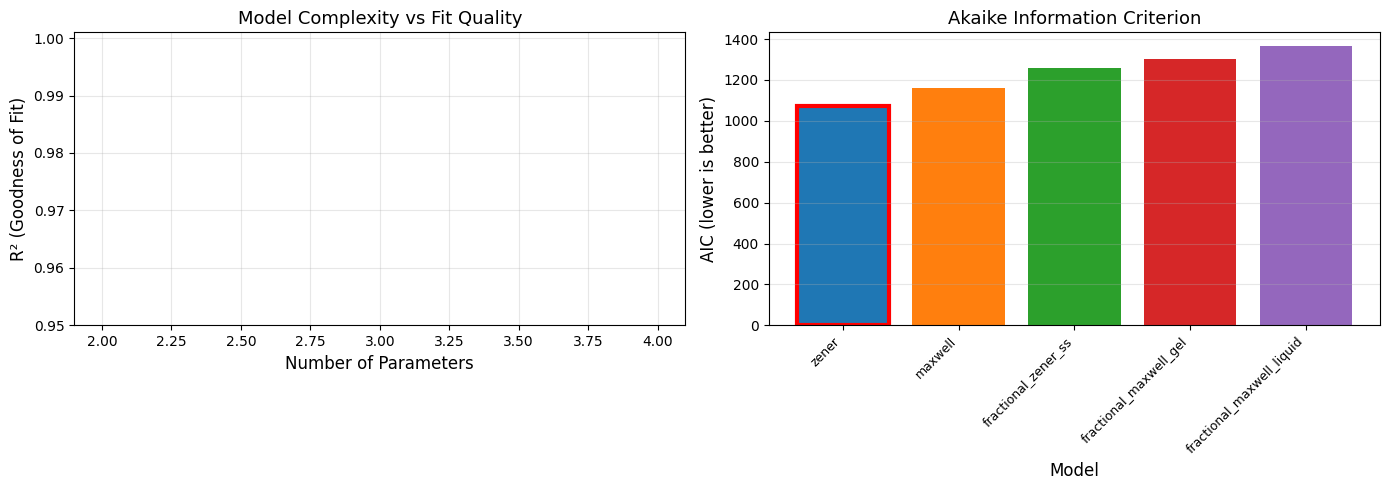

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: R² vs number of parameters
ax1.plot(df_comparison_sorted['Parameters'], df_comparison_sorted['R²'], 
         'o-', markersize=10, linewidth=2)
for i, model in enumerate(df_comparison_sorted['Model']):
    ax1.annotate(model, 
                (df_comparison_sorted['Parameters'].iloc[i], 
                 df_comparison_sorted['R²'].iloc[i]),
                textcoords="offset points", xytext=(0,10), 
                ha='center', fontsize=8)
ax1.set_xlabel('Number of Parameters', fontsize=12)
ax1.set_ylabel('R² (Goodness of Fit)', fontsize=12)
ax1.set_title('Model Complexity vs Fit Quality', fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.95, 1.001])

# Right: AIC comparison
x_pos = np.arange(len(df_comparison_sorted))
bars = ax2.bar(x_pos, df_comparison_sorted['AIC'], color=colors[:len(df_comparison_sorted)])
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('AIC (lower is better)', fontsize=12)
ax2.set_title('Akaike Information Criterion', fontsize=13)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(df_comparison_sorted['Model'], rotation=45, ha='right', fontsize=9)
ax2.grid(True, alpha=0.3, axis='y')

# Highlight best model
bars[0].set_edgecolor('red')
bars[0].set_linewidth(3)

plt.tight_layout()
display(fig)
plt.close(fig)


## Conclusion

In this notebook, we performed systematic model comparison for rheological data:

### Key Findings:

1. **Model Selection**: Information criteria (AIC, BIC) balance fit quality against complexity
2. **Best Model**: The model with lowest AIC/BIC is statistically preferred
3. **Complexity Trade-off**: More parameters improve R² but may overfit (penalized by AIC/BIC)
4. **Residual Patterns**: Systematic residuals indicate model inadequacy

### Interpretation Guidelines:

- **ΔA IC < 2**: Models are essentially equivalent
- **2 < ΔAIC < 4**: Moderate evidence favoring best model  
- **4 < ΔAIC < 7**: Strong evidence favoring best model
- **ΔAIC > 10**: Very strong evidence favoring best model

### When to Use Each Model:

- **Maxwell**: Purely viscous liquids with single relaxation time
- **Zener**: Materials with equilibrium modulus (gels, crosslinked polymers)
- **Fractional Models**: Materials with broad relaxation spectra (power-law behavior)
- **Complex Fractional**: Multi-modal relaxation with fractional components

### Recommendations:

1. Always compare multiple models systematically
2. Use information criteria (AIC/BIC) for objective selection
3. Examine residuals for systematic patterns
4. Consider physical interpretability of parameters
5. Validate selected model with independent test data

### Next Steps:

- Apply multi-technique fitting (see `multi_technique_fitting.ipynb`)
- Perform advanced sensitivity analysis (see `advanced_workflows.ipynb`)
- Explore Bayesian model selection with uncertainty quantification (Phase 3)